# Hospitlization Risk Prediction Using CMS-HCC Scores

# Objective:

In this project, we're going to build a predictive model to identify patients with costly healthcare outcomes using CMS-HCC risk adjustment scores and patient data. The CMS-HCC scores are an approach to quantify patient comorbidities using weights associated with each condition based on its expected impact on healthcare costs. This approach aims to simulate how insureres might use predictive analyitcs to proactively manage high risk members and reduce avoidable costs and premiums.

# 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_recall_curve
import xgboost as xgb
import shap

# 2. Simulate Patient Data

We're going to assume 500 adult patients, with various backgrounds and age range (18-90) and we also have their icd-10 codes each patient has 1 to 3 conditions and their prior year cost.

For simplicity sake, we are using 5 ICD-10 codes. Two diabetes codes one for chronic complications and another for major complications. One for hypertension (high blood pressure), one for chronic obstructive pulmonary disease (COPD), and lastly one for chrnoic kidney disease (CKD).

These ICD-10 codes are mapped to a Hierarchical Condition Category (HCC) provided by the CMS which weights are assigned to each HCC code.

If a patient has multiple HCCs in the same group, only the highest weight is counted and HCCs in different groups are independent. So, in our example, because we have two diabetes codes, the HCC with the greater weight will supersede the other.

We're going to use a binomial distribution to flag if the patients are a hospitalization risk or not with a 20% chance if they're under 60 years of age, otherwise, they have a 40% chance.

In [2]:
# initiate with sample size and random seed

np.random.seed(42)
n_patients = 500

In [3]:
# patient demographics

patients = pd.DataFrame({
    'age': np.random.randint(18, 90, size = n_patients),
    'gender': np.random.choice(['male', 'female'], size = n_patients),
    'race': np.random.choice(['white', 'black', 'hispanic', 'asian', 'other'], size = n_patients),
    'patient_id': range(1, n_patients + 1),
    'prior_year_cost': np.random.randint(1_000, 10_000, size = n_patients)
})

In [4]:
patients

,age,gender,race,patient_id,prior_year_cost
0,69,female,hispanic,1,3265
1,32,female,asian,2,1936
2,89,male,other,3,7402
3,78,male,hispanic,4,4845
4,38,male,hispanic,5,2796
...,...,...,...,...,...
495,34,female,other,496,8327
496,88,female,black,497,9841
497,62,female,hispanic,498,2100
498,21,male,black,499,7652


In [5]:
# assign random icd-10 codes

icd_codes = [
    'E11.22',
    'E11.65',
    'I10',
    'J44.9',
    'N18.9'
]

patients['icd_10'] = [np.random.choice(icd_codes, size = np.random.randint(1, 3), replace = False).tolist() for _ in range(n_patients)]


In [6]:
patients

,age,gender,race,patient_id,prior_year_cost,icd_10
0,69,female,hispanic,1,3265,"[J44.9, N18.9]"
1,32,female,asian,2,1936,[E11.22]
2,89,male,other,3,7402,[E11.65]
3,78,male,hispanic,4,4845,"[E11.22, N18.9]"
4,38,male,hispanic,5,2796,"[N18.9, E11.22]"
...,...,...,...,...,...,...
495,34,female,other,496,8327,"[J44.9, E11.22]"
496,88,female,black,497,9841,"[I10, J44.9]"
497,62,female,hispanic,498,2100,[N18.9]
498,21,male,black,499,7652,"[J44.9, N18.9]"


In [7]:
# assign probability based on age 40% if greater than 60 years of age

np.random.seed(42)
hospitalization_prob = np.where(patients['age'] > 60, 0.4, 0.2)

# simulate hospitalization outcome (assuming binary)

patients['hospitalization'] = np.random.binomial(1, hospitalization_prob)

In [8]:
patients

,age,gender,race,patient_id,prior_year_cost,icd_10,hospitalization
0,69,female,hispanic,1,3265,"[J44.9, N18.9]",0
1,32,female,asian,2,1936,[E11.22],1
2,89,male,other,3,7402,[E11.65],1
3,78,male,hispanic,4,4845,"[E11.22, N18.9]",0
4,38,male,hispanic,5,2796,"[N18.9, E11.22]",0
...,...,...,...,...,...,...,...
495,34,female,other,496,8327,"[J44.9, E11.22]",0
496,88,female,black,497,9841,"[I10, J44.9]",0
497,62,female,hispanic,498,2100,[N18.9],0
498,21,male,black,499,7652,"[J44.9, N18.9]",1


In [9]:
count_risk = patients['hospitalization'].value_counts()
print(count_risk)

hospitalization
0    354
1    146
Name: count, dtype: int64


# 3. Map ICD-10 Codes to HCC Codes and Weights to Get Risk Scores

Here we're going to create a table listing the HCC code, description of the code, assigned weights, what hierarchy group the code belongs to, and the ICD-10 codes.

Then we're going to create a function where it returns a dictionary list of HCC codes, weights, and group associated to each provided ICD-10 code.

Using this mapping function, we're going to create a scoring function to assess health risk providing it the patient's ICD-10 codes and age. This scoring function, will iterate through each patient's conditions, look up the corresponding hierarchy group and weight, assign the group to a object variable and compare it if it's already in a scoring dictionary or not. If it is not, then the group key placed in the scoring dictionary along with it's weight. But, if the group key is already in the scoring dictionary then compare the weights. If the one in the dictionary is less, then the greater one will be the weight for this group. All scores for a patient's conditions are tallied up. Finally, it looks at the age, if they're greater than 60, 0.15 will be added to the score.


In [10]:
hcc_table = pd.DataFrame({
    'HCC': [18, 19, 108, 111, 138],
    'Description': [
        'Diabetes with chronic complications',
        'Diabetes with major complications',
        'Hypertension',
        'Chronic obstructive pulmonary disease',
        'Chronic kidney disease'
    ],
    'Weight': [0.318, 0.420, 0.115, 0.277, 0.308],
    'Hierarchy_group': [
        'Diabetes',
        'Diabetes',
        'Hypertension',
        'COPD',
        'CKD'
    ],
    'ICD-10': ['E11.22', 'E11.65', 'I10', 'J44.9', 'N18.9']
})

In [11]:
hcc_table

,HCC,Description,Weight,Hierarchy_group,ICD-10
0,18,Diabetes with chronic complications,0.318,Diabetes,E11.22
1,19,Diabetes with major complications,0.420,Diabetes,E11.65
2,108,Hypertension,0.115,Hypertension,I10
3,111,Chronic obstructive pulmonary disease,0.277,COPD,J44.9
4,138,Chronic kidney disease,0.308,CKD,N18.9


In [12]:
def map_icd_to_hcc(icd_list):
    matched = []
    icd_set = set(icd_list)
    for _, row in hcc_table.iterrows(): # using _ since don't need index info from iterrows()
        icd_row = row['ICD-10']
        if isinstance(icd_row, str): # checks if obj is just a string, true or false
            icd_row = [icd_row]
        if icd_set.intersection(icd_row): #
            matched.append({
                'HCC': row['HCC'],
                'Weight': row['Weight'],
                'Hierarchy_group': row['Hierarchy_group']
            })
    return matched

In [13]:
print(map_icd_to_hcc(patients['icd_10'].iloc[0]))

[{'HCC': 111, 'Weight': 0.277, 'Hierarchy_group': 'COPD'}, {'HCC': 138, 'Weight': 0.308, 'Hierarchy_group': 'CKD'}]


In [14]:
def calc_hcc_score(icd_list, age):
  matched_hccs = map_icd_to_hcc(icd_list)

  scoring_dict = {}
  for hcc_dict in matched_hccs:
    group = hcc_dict['Hierarchy_group']
    if group not in scoring_dict or hcc_dict['Weight'] > scoring_dict[group]:
      scoring_dict[group] = hcc_dict['Weight']
  score = sum(scoring_dict.values())

  if age > 60:
    score += 0.15
  return score

In [15]:
# calc and add the risk_score to patients table apply the calc_hcc_score fct using the icd codes and age column from that table
# axis = 1 bc apply fct across each row since need each patient's icd and age

patients['risk_score'] = patients.apply(lambda x: calc_hcc_score(x['icd_10'], x['age']), axis = 1)

In [16]:
patients

,age,gender,race,patient_id,prior_year_cost,icd_10,hospitalization,risk_score
0,69,female,hispanic,1,3265,"[J44.9, N18.9]",0,0.735
1,32,female,asian,2,1936,[E11.22],1,0.318
2,89,male,other,3,7402,[E11.65],1,0.570
3,78,male,hispanic,4,4845,"[E11.22, N18.9]",0,0.776
4,38,male,hispanic,5,2796,"[N18.9, E11.22]",0,0.626
...,...,...,...,...,...,...,...,...
495,34,female,other,496,8327,"[J44.9, E11.22]",0,0.595
496,88,female,black,497,9841,"[I10, J44.9]",0,0.542
497,62,female,hispanic,498,2100,[N18.9],0,0.458
498,21,male,black,499,7652,"[J44.9, N18.9]",1,0.585


# 4. Modeling

Here we'll model patient characteristics including gender, age, and CMS-HCC risk scores to predict costly healthcare outcomes, proxied by the likelihood of hospitalization. The model’s predictions are evaluated against the observed (after-the-fact) hospitalization indicator.

We'll compare a transparent Logistic Regression model to serve as a baseline with a high-performance Gradient Boosting Machine (GBM) model.

## 4.1 Feature Preparation

Here we'll prepare the features (gender, age, and CMS-HSS risk scores) and target (hospitalization) variables. Since gender is categorical, we'll dummy variable encode this feature so if they are male, it'll be 1 and 0 if female into a new column in the patients dataframe.

In [17]:
patients['gender_m'] = (patients['gender']=='male').astype(int)

X = patients[['age', 'risk_score', 'gender_m']]
y = patients['hospitalization']

In [18]:
# train test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# standardize after splitting to prevent data leakage

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 4.2 Modeling: Logistic Regression v GBM

In [19]:
# logistic regression

logreg = LogisticRegression()
logreg.fit(X_train_scaled, y_train)

y_pred_prob_logreg = logreg.predict_proba(X_test_scaled)[:, 1]
y_pred_logreg = logreg.predict(X_test_scaled)

print("=== Logistic Regression Performance ===\n")
print("ROC - AUC:", round(roc_auc_score(y_test, y_pred_prob_logreg), 4), "\n")
print(classification_report(y_test, y_pred_logreg))

=== Logistic Regression Performance ===

ROC - AUC: 0.443 

              precision    recall  f1-score   support

           0       0.77      1.00      0.87        77
           1       0.00      0.00      0.00        23

    accuracy                           0.77       100
   macro avg       0.39      0.50      0.44       100
weighted avg       0.59      0.77      0.67       100



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [20]:
# random forest

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 100, random_state = 42)
rf.fit(X_train, y_train)

y_pred_prob_rf = rf.predict_proba(X_test)[:, 1]
y_pred_rf = rf.predict(X_test)

print("=== Random Forest Performance ===\n")
print("ROC - AUC:", round(roc_auc_score(y_test, y_pred_prob_rf), 4), "\n")
print(classification_report(y_test, y_pred_rf))

=== Random Forest Performance ===

ROC - AUC: 0.4365 

              precision    recall  f1-score   support

           0       0.77      0.77      0.77        77
           1       0.22      0.22      0.22        23

    accuracy                           0.64       100
   macro avg       0.49      0.49      0.49       100
weighted avg       0.64      0.64      0.64       100



In [21]:
# xgboost

gbm = xgb.XGBClassifier(
    n_estimators = 100,
    max_depth = 3,
    learning_rate = 0.1,
    random_state = 42
)

gbm.fit(X_train, y_train)

y_pred_prob_gbm = gbm.predict_proba(X_test)[:, 1]
y_pred_gbm = gbm.predict(X_test)

print("=== Gradient Boosting Machine Performance ===\n")
print("ROC - AUC:", round(roc_auc_score(y_test, y_pred_prob_gbm), 4), "\n")
print(classification_report(y_test, y_pred_gbm))

=== Gradient Boosting Machine Performance ===

ROC - AUC: 0.4876 

              precision    recall  f1-score   support

           0       0.78      0.86      0.81        77
           1       0.27      0.17      0.21        23

    accuracy                           0.70       100
   macro avg       0.52      0.52      0.51       100
weighted avg       0.66      0.70      0.68       100



/tmp/ipython-input-2230205503.py:7: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test, plot_type = 'bar')


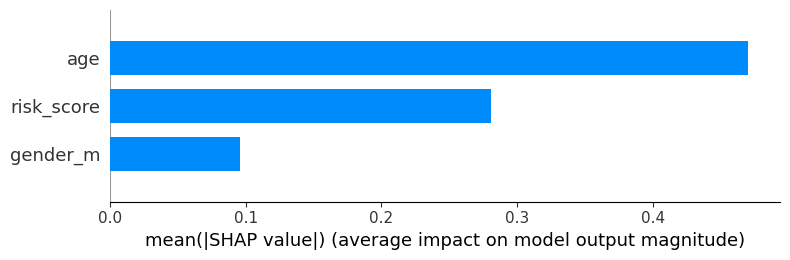

In [28]:
# SHAP feature importance for XGBoost

rng = np.random.default_rng(42)
explainer = shap.TreeExplainer(gbm)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type = 'bar')

## 4.3 Model Performance & Interpretation

After evaluating three predictive models to predict costly healthcare outcomes proxied by hospitlization all models struggled to identify hospitalized patients.

Logistic regression struggled to identify hospitalized patients, achieving an ROC-AUC score of 0.443 meaning it performed worse than randomly guessing (50%). This model also failed to predict any true positives as both precision and recall for hospitalized patients were 0. Precision measures how many of the examples the model predicted as positive were actually positive.  Recall measures how many of the actual positive examples did the model correctly identify. Its 77% accuracy is misleading because the model predominately predicted non-hospitalization.

The random forest classifier had a slightly worse ROC-AUC score than the logistic regression model at 0.436. However, its class 1 recall and precision metrics are both at 22% which performed much better than logistic regression's outcome.

XGBoost provided slight improvements where its precision score of 0.27 but its recall score was 0.17 indicating it captures hospitalization flags worse than random forest but still better than logistic regression. However, its ROC-AUC score was 0.488 -- still worse than randomly guessing just like the baseline logistic regression model.

Because this is a business use case that involves trying to minimize healthcare cost, the metric we should prioritize is recall. Recall measures correct positives among actual positives and in this context we want to accurately measure hospitalized patients. Missing a positive case (false negatives) is costly, so maximizing recall ensures we don't mislabel hospitalized patients.

Model performance can be suffering because of the default threshold used in both models. 50% threshold to discriminate between hospitalized vs non-hospitalized patients might be too high. In determinign thresholds, we have to look at the tradeoffs between detecting positives (recall) and minimizing false positives (precision).

## 4.4 Model Fine Tuning

We use the formal F_beta score formula where when beta = 1, it's the normal F1 score trying to balance precision and recall. When beta > 1, we emphasize recall, while when beta < 1, we emphasize precision.

$$
F_\beta = (1 + \beta^2) \cdot \frac{\text{precision} \cdot \text{recall}}{(\beta^2 \cdot \text{precision}) + \text{recall}}
$$

Beta can be empirically tuned by estimating the cost of detecting a false negative and a false positive.

$$
\beta^2 = \frac{\text{Cost of FN}}{\text{Cost of FP}}
$$



In [23]:
y_scores = y_pred_prob_logreg

# compute precision and recall values and their thresholds

precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# find f scores for each threshold

beta_f = [1, 1.5, 2]

f_scores_dict = {}
for beta in beta_f:
  f_scores = (1 + (beta)**2) * (precision[:-1] * recall[:-1]) / (((beta)**2) * precision[:-1] + recall[:-1])
  f_scores_dict[beta] = f_scores

# find the threshold with the highest F1 score using same index
best_thresholds = {}
for beta, f_scores in f_scores_dict.items():
  best_threshold_idx = np.argmax(f_scores)
  best_thresholds[beta] = thresholds[best_threshold_idx]


/tmp/ipython-input-1502450887.py:13: RuntimeWarning: invalid value encountered in divide
  f_scores = (1 + (beta)**2) * (precision[:-1] * recall[:-1]) / (((beta)**2) * precision[:-1] + recall[:-1])


In [24]:
print("=== Optimal Thresholds ===\n")
for beta, thresh in best_thresholds.items():
    print(f"Beta = {beta}: Threshold = {thresh:.3f}")

=== Optimal Thresholds ===

Beta = 1: Threshold = 0.440
Beta = 1.5: Threshold = 0.440
Beta = 2: Threshold = 0.440


Apply optimal threshold to logistic regression model.



In [25]:
y_pred = (y_pred_prob_logreg >= best_thresholds[1.5]).astype(int)

print("=== Logistic Regression Classification Report ===\n")
print(classification_report(y_test, y_pred))


=== Logistic Regression Classification Report ===

              precision    recall  f1-score   support

           0       0.77      0.97      0.86        77
           1       0.00      0.00      0.00        23

    accuracy                           0.75       100
   macro avg       0.38      0.49      0.43       100
weighted avg       0.59      0.75      0.66       100



Apply logistic regression with class balance and optimal threshold

In [26]:
# logistic regression with balanced class weight and threshold = 0.44

logreg = LogisticRegression(class_weight = 'balanced', random_state = 42)
logreg.fit(X_train_scaled, y_train)

y_pred_prob_logreg = logreg.predict_proba(X_test_scaled)[:, 1]

# apply the threshold
y_pred_logreg_thresholded = (y_pred_prob_logreg >= 0.44).astype(int)


print("=== Logistic Regression Performance (Balanced Class Weight and Threshold 0.44) ===\n")
print("ROC - AUC:", round(roc_auc_score(y_test, y_pred_prob_logreg), 4), "\n")
print(classification_report(y_test, y_pred_logreg_thresholded))

=== Logistic Regression Performance (Balanced Class Weight and Threshold 0.44) ===

ROC - AUC: 0.4424 

              precision    recall  f1-score   support

           0       0.72      0.17      0.27        77
           1       0.22      0.78      0.34        23

    accuracy                           0.31       100
   macro avg       0.47      0.48      0.31       100
weighted avg       0.61      0.31      0.29       100



##4.5 Model Evaluation

The logistic regression model with class weighting and threshold tuning performed significantly better than the baseline logistic regression model in terms of recall. With a recall of 0.78, the model correctly identified 78% of the actual hospitalized patients. However, by emphasizing recall, the model traded off precision where the class 1 0.22 precision score indicates that only 22% of the cases predicted as positive were truly hospitalized, meaning the model produced many false positives. Despite the improved recall, the ROC-AUC score of 0.442 shows that the model’s overall discriminative ability was poor, performing about as poorly as the baseline logistic regression model, the random forest classifier, and the XGBoost model where all are worse than randomly guessing.

# 5. Conclusion

Given the attempts to fine tune the classification threshold and address the class imbalance from the baseline logistic regression model, all models failed to accuractely distinguish between high and low risk patients. While threshold tuning improved recall by identifying 78% of the hospitalized cases, it came at a cost of a drop in precision leading to an increase in false positives where low risk patients were flagged as high risk.

In a risk adjustment or insurance setting, a too low precision could lead to inefficient resource allocation and inflated costs as care management teams might focus on patients who are unlikely to require costly medical interventions increasing administrative overhead with little clinical benefit. Also, since our model over-identifies high risk patients because of the high false positive rate, it can inflate reported risk scores and lead to audit exposure or penalties.

Future improvements could include incoporating additional patient and clincial variables, but most importantly the limitation may partly stem from the simplified hospitalization flag simulation where hospitalization probability was deterministically tied to age where they had a 40% chance if they were over 60 and 20% otherwise. Such a setup reduces the natural variability and complexity seen in real-world data and thus makes it harder for models to learn nuanced risk patterns. Future iterations could remedy this with enriched data simulation with additional clinical, behavioral, and possibly socio-economic factors.